In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

os.chdir('/content/drive/MyDrive/CDE/PracticalWorkshop/Dataset/')

In [ ]:
#!unzip 'Track1.zip'

In [ ]:
!pip install rasterio torchmetrics -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 55.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.2/840.2 kB 61.2 MB/s eta 0:00:00


In [ ]:
import os
import numpy as np
from PIL import Image
import rasterio

import torch
from torchvision.transforms import transforms
import torchvision.datasets as datasets
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torchvision import models
from torch.nn.functional import relu
import torch.optim as optim
from sklearn.metrics import accuracy_score
import torch.nn.functional as F

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

In [ ]:
#@title PixelClassificationDataset
class PixelClassificationDataset(Dataset):
    def __init__(self, feature_folder, label_folder, transform = None):
        self.feature_folder = feature_folder
        self.label_folder = label_folder
        self.feature_files = [f for f in os.listdir(feature_folder) if f.endswith(('.tif'))]
        self.label_files = [f for f in os.listdir(label_folder) if f.endswith(('.png'))]
        self.transform = transform

    def __len__(self):
        return len(self.feature_files)

    def __getitem__(self, idx):
        # Load feature image using rasterio
        feature_file = self.feature_files[idx]
        feature_path = os.path.join(self.feature_folder, feature_file)
        feature_img = rasterio.open(feature_path).read()
        feature_array = np.array(feature_img).transpose(1,2,0) # Convert feature image to numpy array

        # Load corresponding label image using PIL
        label_file = self.label_files[idx]
        label_path = os.path.join(self.label_folder, label_file)
        label_img = Image.open(label_path)
        label_array = np.array(label_img)  # Convert label image to numpy array

        if self.transform:
            feature_array = self.transform(feature_array)

        return (feature_array, label_array)

In [ ]:
feature_folder = "./Track1/subsample/train/images"
label_folder = './Track1//subsample/train/labels'



batch_size = 12

# Create an instance of the custom dataset
dataset = PixelClassificationDataset(feature_folder,
                                     label_folder,
                                     transform = transforms.ToTensor()
                                     )

train_set, val_set = torch.utils.data.random_split(dataset, [160,40])

train_loader = DataLoader(dataset = train_set, batch_size = batch_size, shuffle = True)
val_loader = DataLoader(dataset = val_set, batch_size = batch_size, shuffle = True)


In [ ]:
len(dataset)

200

In [ ]:
train_set[0][1].min()

/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


0

In [ ]:
#@title U-NET
class UNet(nn.Module):
    def __init__(self, n_class, n_input):
        super(UNet, self).__init__()

        # Encoder
        # input: 512*512x6
        self.e11 = nn.Conv2d(n_input, 64, kernel_size=3, padding=1)  #510*510*64
        self.e12 = nn.Conv2d(64, 64, kernel_size=3, padding=1) #508*508*64
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) #254*254*64

        # input: 254*254*64
        self.e21 = nn.Conv2d(64, 128, kernel_size=3, padding=1) #252*252*128
        self.e22 = nn.Conv2d(128, 128, kernel_size=3, padding=1) #250*250*128
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) #125*125*128

        #input: 125*125*128
        self.e31 = nn.Conv2d(128, 256, kernel_size=3, padding=1) #123*123*256
        self.e32 = nn.Conv2d(256, 256, kernel_size=3, padding=1) #121 * 121 *256
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2) # 60 * 60*256

        #input: 60*60*256
        self.e41 = nn.Conv2d(256, 512, kernel_size=3, padding=1) #58*58*512
        self.e42 = nn.Conv2d(512, 512, kernel_size=3, padding=1) #56*56*512
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2) # 28*28*512

        #input: 28*28*512
        self.e51 = nn.Conv2d(512, 1024, kernel_size=3, padding=1) #26*26*1024
        self.e52 = nn.Conv2d(1024, 1024, kernel_size=3, padding=1) #24*24*1024

        # Decoder
        self.upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.d11 = nn.Conv2d(1024, 512, kernel_size=3, padding=1)
        self.d12 = nn.Conv2d(512, 512, kernel_size=3, padding=1)

        self.upconv2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.d21 = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.d22 = nn.Conv2d(256, 256, kernel_size=3, padding=1)

        self.upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.d31 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.d32 = nn.Conv2d(128, 128, kernel_size=3, padding=1)

        self.upconv4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.d41 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.d42 = nn.Conv2d(64, 64, kernel_size=3, padding=1)

        # Output layer
        self.outconv = nn.Conv2d(64, n_class, kernel_size=1)

    def forward(self, x):
        # Encoder
        xe11 = F.relu(self.e11(x.float()))
        xe12 = F.relu(self.e12(xe11))
        xp1 = self.pool1(xe12)

        xe21 = F.relu(self.e21(xp1))
        xe22 = F.relu(self.e22(xe21))
        xp2 = self.pool2(xe22)

        xe31 = F.relu(self.e31(xp2))
        xe32 = F.relu(self.e32(xe31))
        xp3 = self.pool3(xe32)

        xe41 = F.relu(self.e41(xp3))
        xe42 = F.relu(self.e42(xe41))
        xp4 = self.pool4(xe42)

        xe51 = F.relu(self.e51(xp4))
        xe52 = F.relu(self.e52(xe51))

        # Decoder
        xu1 = self.upconv1(xe52)
        xu11 = torch.cat([xu1, xe42], dim=1)
        xd11 = F.relu(self.d11(xu11))
        xd12 = F.relu(self.d12(xd11))

        xu2 = self.upconv2(xd12)
        xu22 = torch.cat([xu2, xe32], dim=1)
        xd21 = F.relu(self.d21(xu22))
        xd22 = F.relu(self.d22(xd21))

        xu3 = self.upconv3(xd22)
        xu33 = torch.cat([xu3, xe22], dim=1)
        xd31 = F.relu(self.d31(xu33))
        xd32 = F.relu(self.d32(xd31))

        xu4 = self.upconv4(xd32)
        xu44 = torch.cat([xu4, xe12], dim=1)
        xd41 = F.relu(self.d41(xu44))
        xd42 = F.relu(self.d42(xd41))

        # Output layer
        out = self.outconv(xd42)

        return out

In [ ]:
#@title train_and_evaluate

def train_and_evaluate(model, criterion, optimizer, train_loader, val_loader, num_epochs=40, early_stopping_patience=5, early_stopping_counter_limit=5, device='cuda'):
    best_validation_loss = float('inf')
    early_stopping_counter = 0

    # Lists to store training and testing loss for plotting
    train_losses = []
    test_losses = []

    # Lists to store accuracy for plotting
    train_accuracies = []
    test_accuracies = []

    for epoch in range(num_epochs):
        start_time = time.time()

        # Training
        model.train()
        running_train_loss = 0.0
        train_predictions = []
        train_labels = []

        for batch in train_loader:
            features, labels = batch
            features, labels = features.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(features)

            # Ensure that target labels have the correct data type
            labels = labels.to(torch.long)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item()

            # Store predictions and labels for accuracy calculation
            _, predicted = torch.max(outputs.data, 1)
            train_predictions.extend(predicted.cpu().numpy())
            train_labels.extend(labels.cpu().numpy())

        # Calculate training accuracy
        train_accuracy = torchmetrics.functional.accuracy(torch.tensor(train_predictions).flatten(),
                                                          torch.tensor(train_labels).flatten(),
                                                          task='binary')
        train_accuracies.append(train_accuracy.item())

        # Calculate average training loss
        average_train_loss = running_train_loss / len(train_loader)
        train_losses.append(average_train_loss)

        # Validation
        model.eval()
        running_test_loss = 0.0
        test_predictions = []
        test_labels = []

        with torch.no_grad():
            for batch in val_loader:
                features, labels = batch
                features, labels = features.to(device), labels.to(device)

                outputs = model(features)

                # Ensure that target labels have the correct data type
                labels = labels.to(torch.long)

                loss = criterion(outputs, labels)
                running_test_loss += loss.item()

                # Store predictions and labels for accuracy calculation
                _, predicted = torch.max(outputs.data, 1)
                test_predictions.extend(predicted.cpu().numpy())
                test_labels.extend(labels.cpu().numpy())

        # Calculate testing accuracy
        test_accuracy = torchmetrics.functional.accuracy(torch.tensor(test_predictions).flatten(),
                                                         torch.tensor(test_labels).flatten(),
                                                         task='binary')
        test_accuracies.append(test_accuracy.item())

        # Calculate average testing loss
        average_test_loss = running_test_loss / len(val_loader)
        test_losses.append(average_test_loss)

        # Early stopping
        if average_test_loss < best_validation_loss:
            best_validation_loss = average_test_loss
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1

        end_time = time.time()
        epoch_time = end_time - start_time

        # Print stats for the epoch
        print(f"Epoch {epoch + 1}/{num_epochs} | "
              f"Train Loss: {average_train_loss:.4f} | Train Acc: {train_accuracy.item():.4f} | "
              f"Test Loss: {average_test_loss:.4f} | Test Acc: {test_accuracy.item():.4f} | "
              f"Time: {epoch_time:.2f} seconds")

        if early_stopping_counter >= early_stopping_patience:
            print(f"Early stopping at epoch {epoch + 1}")
            break

    # Plotting
    plt.figure(figsize=(12, 5))

    # Plot training and testing losses
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(test_losses, label='Testing Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot training and testing accuracies
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(test_accuracies, label='Testing Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()


In [ ]:
# Instantiate your U-Net model

torch.cuda.empty_cache()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNet(n_class=2, n_input = 6).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)



In [ ]:
device

device(type='cuda')

/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
<ipython-input-10-227f9ebe0109>:46: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  train_accuracy = torchmetrics.functional.accuracy(torch.tensor(train_predictions).flatten(),


Epoch 1/20 | Train Loss: 3.1613 | Train Acc: 0.8489 | Test Loss: 0.4147 | Test Acc: 0.9181 | Time: 148.32 seconds
Epoch 2/20 | Train Loss: 0.4578 | Train Acc: 0.9317 | Test Loss: 0.2954 | Test Acc: 0.9418 | Time: 61.19 seconds
Epoch 3/20 | Train Loss: 0.3528 | Train Acc: 0.9414 | Test Loss: 0.3036 | Test Acc: 0.9421 | Time: 61.69 seconds
Epoch 4/20 | Train Loss: 0.3857 | Train Acc: 0.9414 | Test Loss: 0.2882 | Test Acc: 0.9421 | Time: 62.43 seconds
Epoch 5/20 | Train Loss: 0.3759 | Train Acc: 0.9414 | Test Loss: 0.2983 | Test Acc: 0.9421 | Time: 60.48 seconds
Epoch 6/20 | Train Loss: 0.3195 | Train Acc: 0.9414 | Test Loss: 0.3759 | Test Acc: 0.9421 | Time: 60.73 seconds
Epoch 7/20 | Train Loss: 0.3021 | Train Acc: 0.9414 | Test Loss: 0.2714 | Test Acc: 0.9420 | Time: 61.34 seconds
Epoch 8/20 | Train Loss: 0.2877 | Train Acc: 0.9413 | Test Loss: 0.3058 | Test Acc: 0.9414 | Time: 59.90 seconds
Epoch 9/20 | Train Loss: 0.2839 | Train Acc: 0.9410 | Test Loss: 0.2626 | Test Acc: 0.9421 | Ti

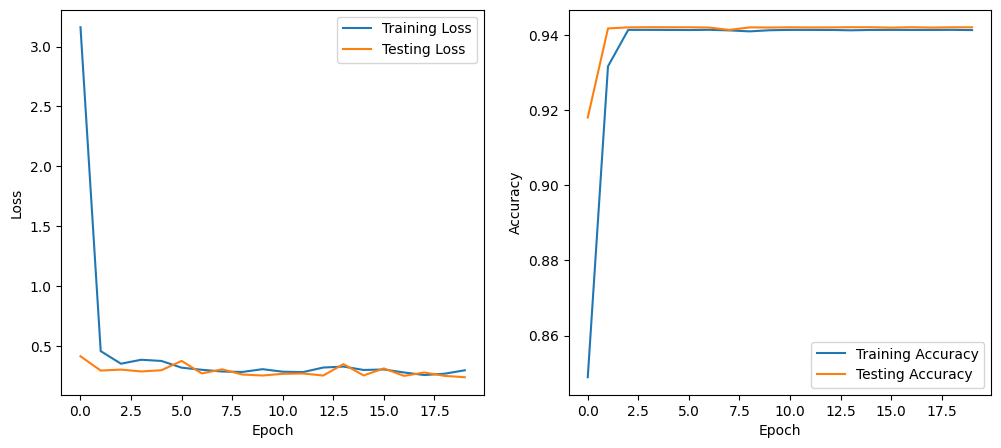

In [ ]:
# Example usage:
import time
import torchmetrics
train_and_evaluate(model,
                   criterion,
                   optimizer,
                   train_loader,
                   val_loader,
                   num_epochs=20,
                   early_stopping_counter_limit=10)


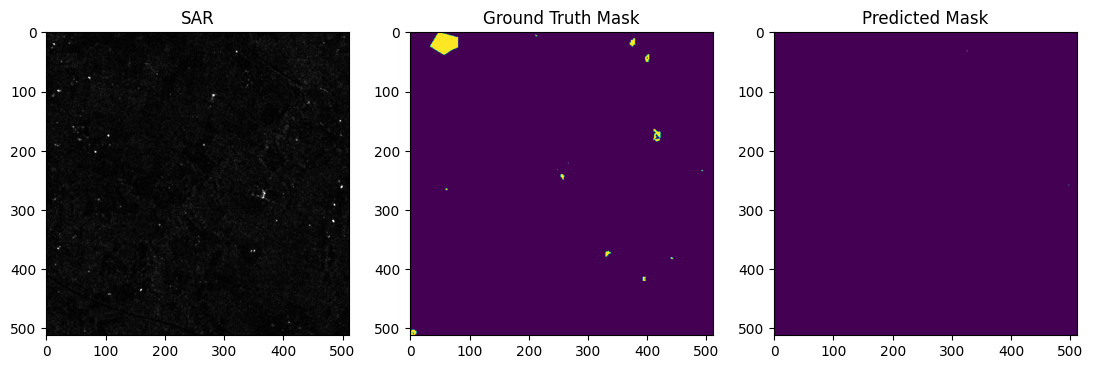

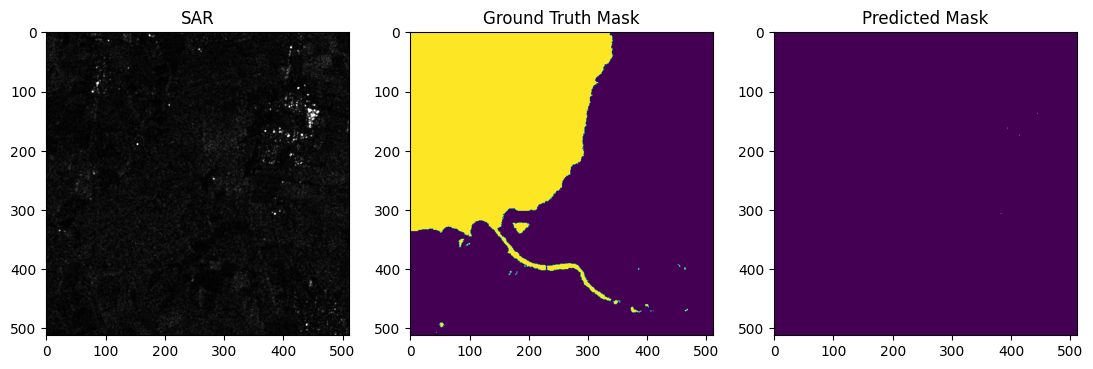

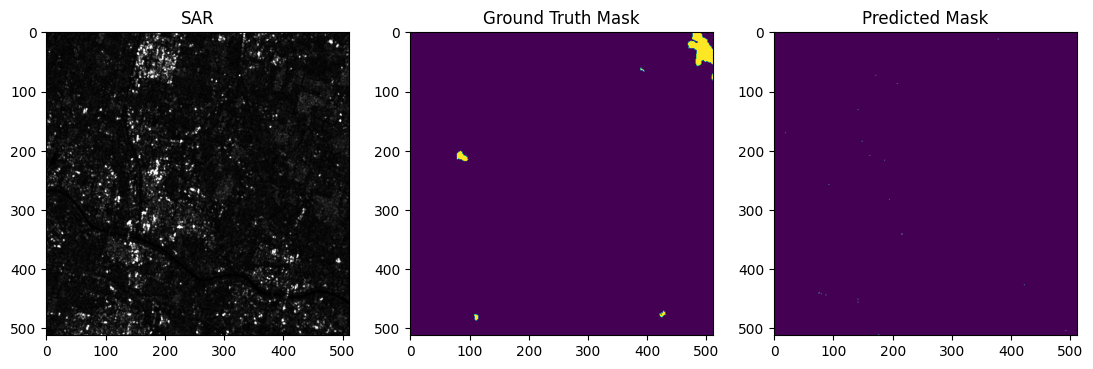

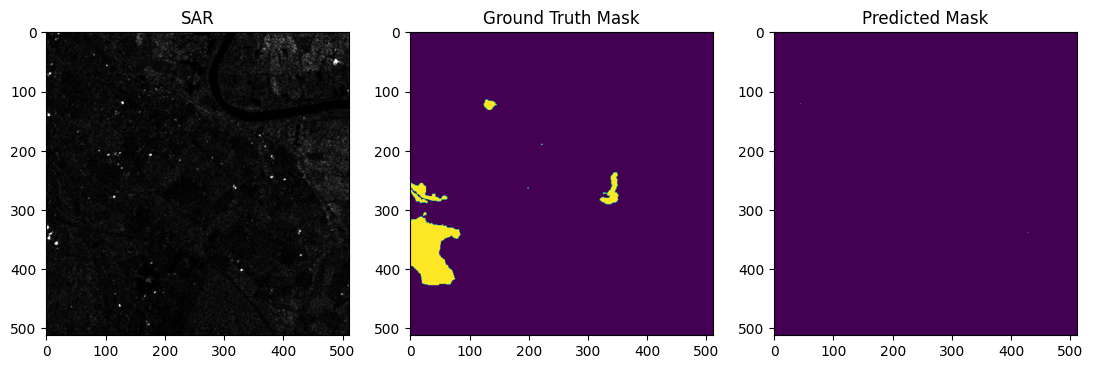

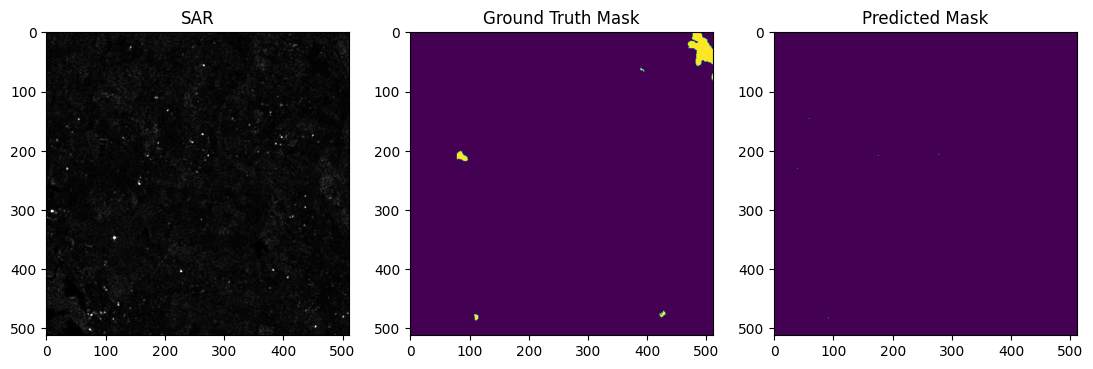

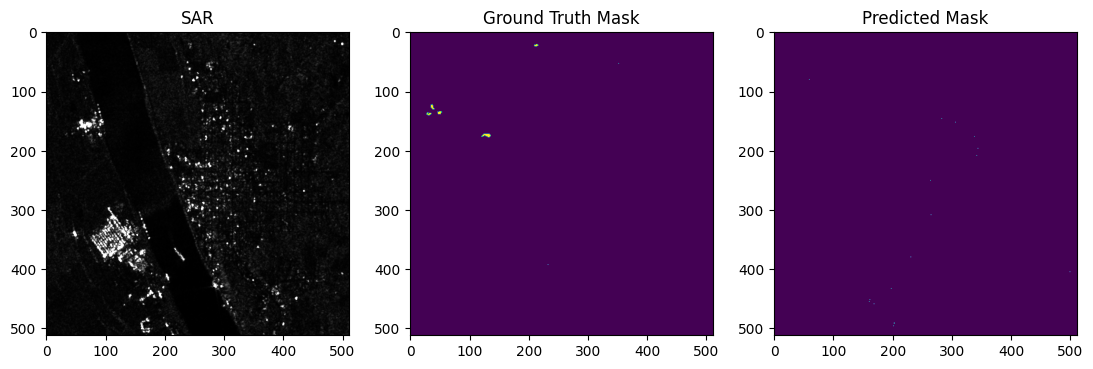

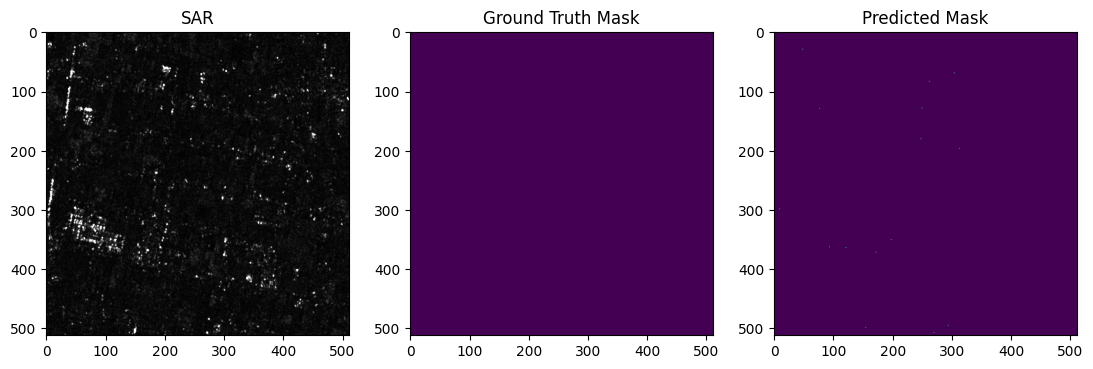

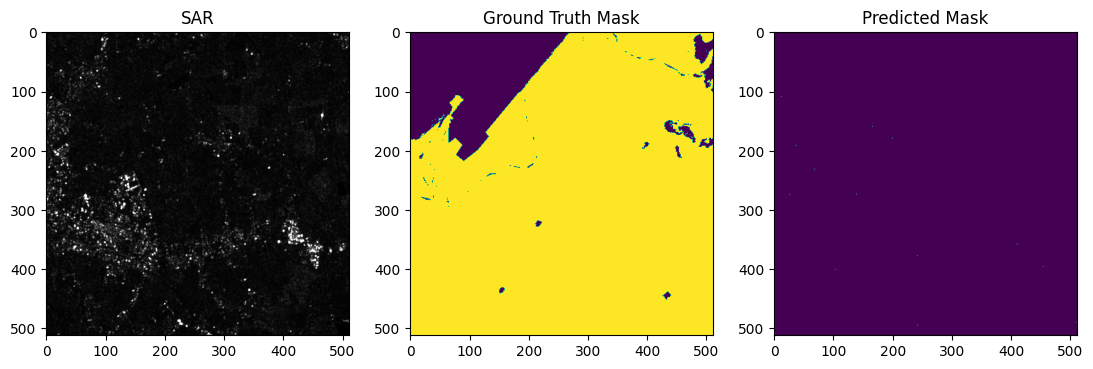

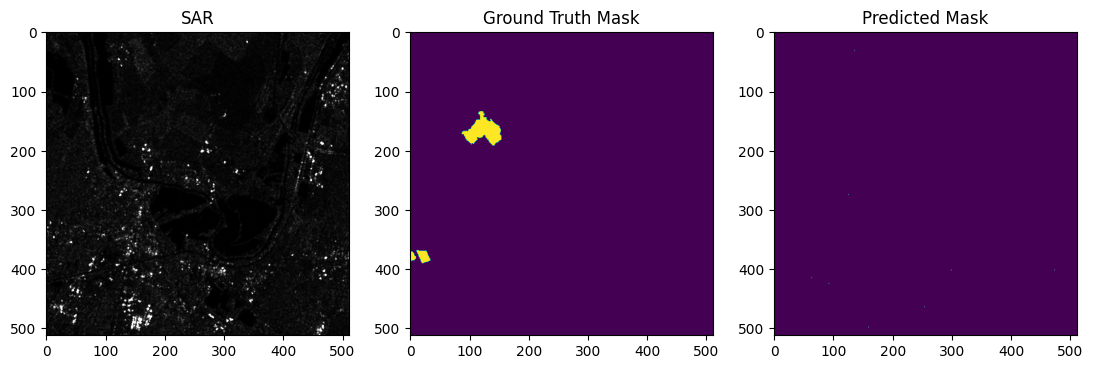

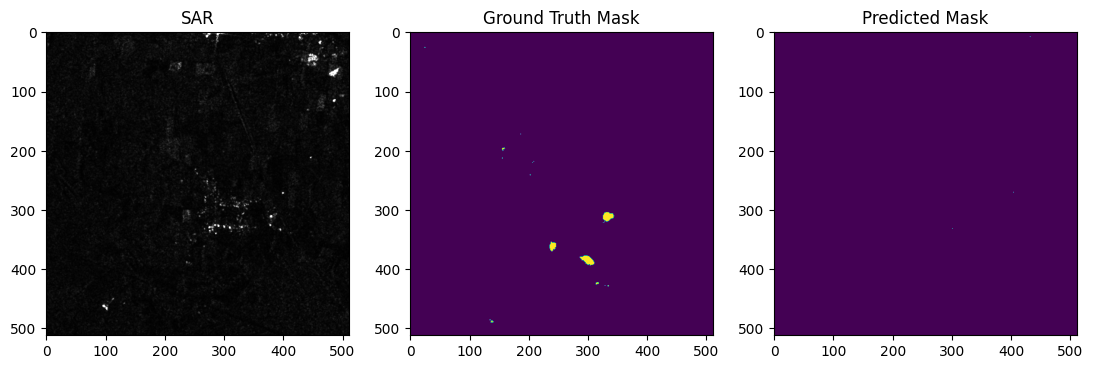

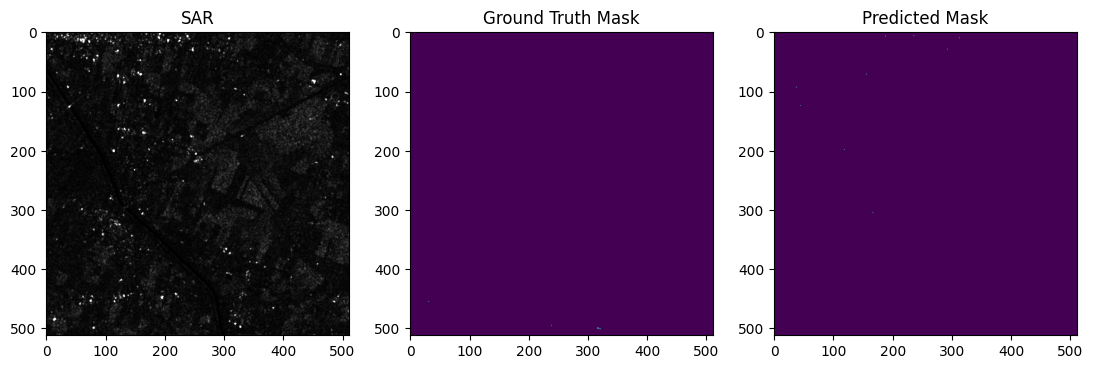

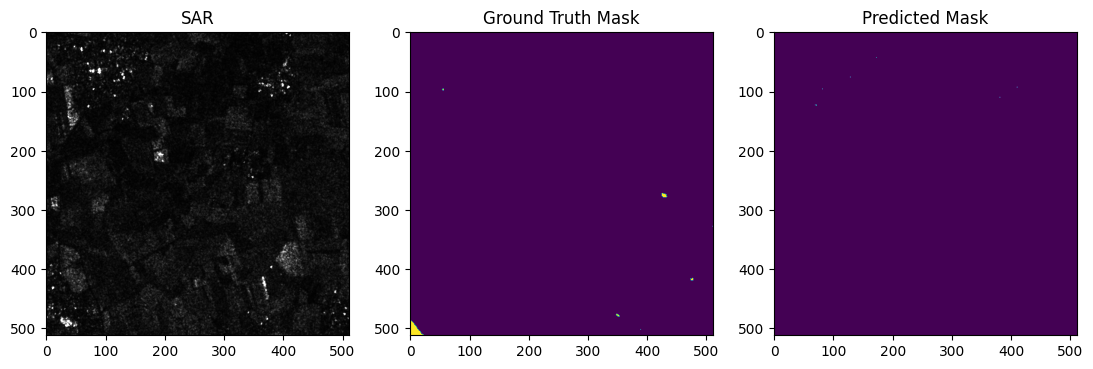

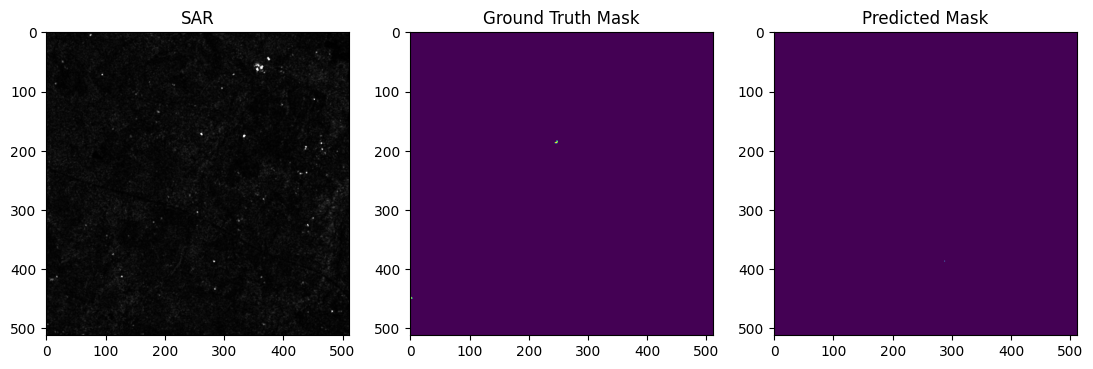

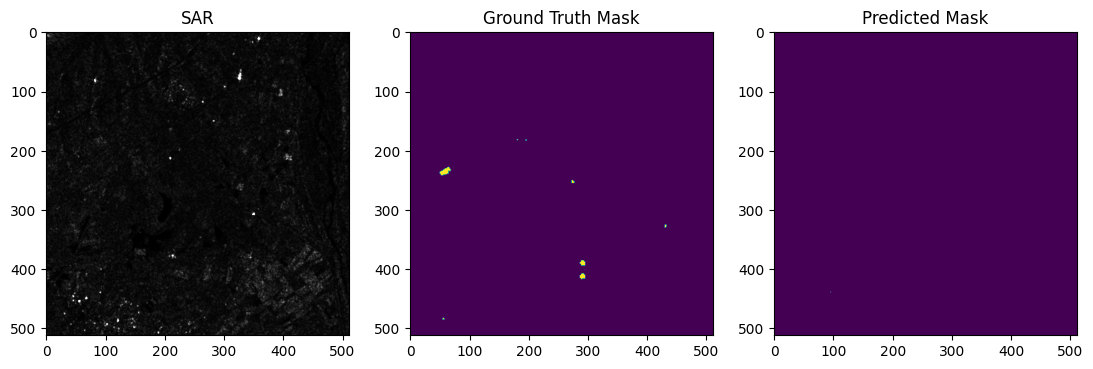

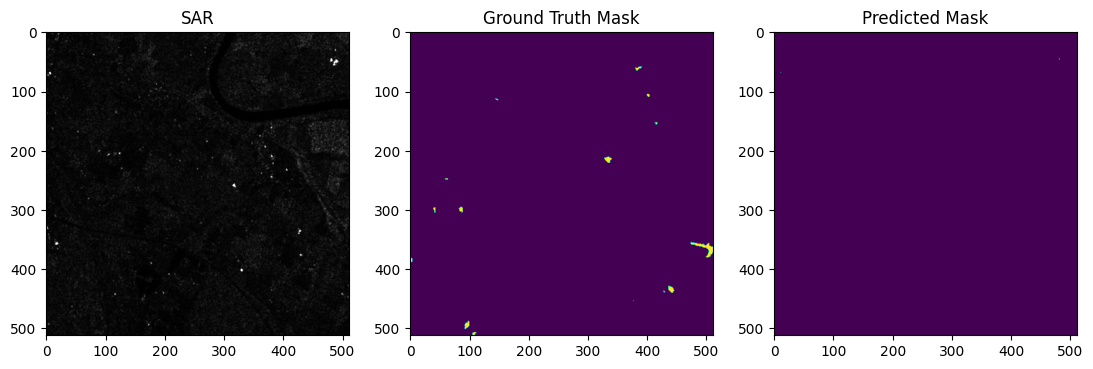

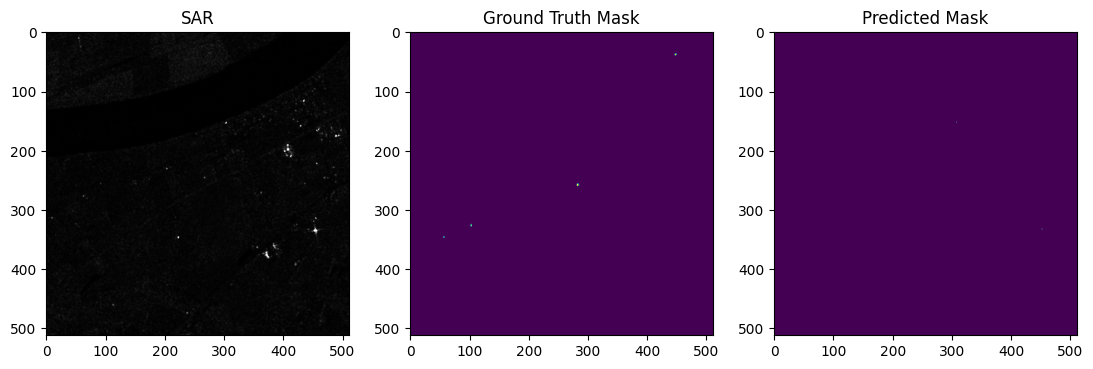

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# ... (your existing code)

def visualize_segmentation(model, val_loader, device='cuda'):
    model.eval()

    with torch.no_grad():
        for batch in val_loader:
            features, labels = batch
            features, labels = features.to(device), labels.to(device)

            outputs = model(features)

            # Convert predictions and labels to numpy arrays
            predicted_masks = torch.argmax(outputs, dim=1).cpu().numpy()
            true_masks = labels.cpu().numpy()

            # Plot some examples
            for i in range(min(4, len(features))):
                plt.figure(figsize=(18, 6))

                plt.subplot(1, 4, 1)
                # Visualize only the first three channels as RGB
                rgb_image = features[i][0].cpu().numpy()
                plt.imshow(rgb_image, cmap = 'gray')
                plt.title('SAR')

                plt.subplot(1, 4, 2)
                plt.imshow(true_masks[i], cmap='viridis')  # Plotting ground truth mask
                plt.title('Ground Truth Mask')

                plt.subplot(1, 4, 3)
                plt.imshow(predicted_masks[i], cmap='viridis')  # Plotting predicted mask
                plt.title('Predicted Mask')


# Example usage:
visualize_segmentation(model, val_loader)


In [ ]:
#find a loss function to compare matrix
#otherwise, flat the array.